# Question 10

Write a Program to implement spatial mean operation (say considering `3×3` window) and applying it on a gray scale noisy image. Show the filtering effect after the variable window size (`5×5`, `7×7`). Discuss the limiting effect of repeatedly applying a `3×3` low pass spatial filter to a digital image (apply `3×3` window two times i.e. twice). Show that the filtering results are equivalent i.e. output image obtained after applying `3×3` window twice is equivalent applying `5×5` window once.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Images to process

In [2]:
path_inp = '../../images/dat/'  # path for input files
path_out_orig = 'originals/'    # path for output files: originals
path_out_conv = 'converted/'    # path for output files: converted

filenames = [
    'f256',
    'l256',
    'o256'
]

ext_inp = '.dat'    # file extention for input
ext_out = '.bmp'    # file extention for output

#### Convert images to numpy array and store in a list of tuples as (filename, np.array)

In [3]:
# Stores the list of dictionaries for the filename, original image, converted image/s
images = []

# Iterate for all filenames
for idx, filename in enumerate(filenames):
    # Store image pixels as uint8 2D array
    image = np.array(
        [i.strip().split() for i in open(path_inp + filename + ext_inp).readlines()],
        dtype='uint8'
    )

    # Add (filename, numpy array of image) into images list
    images.append({
        'filename': filename,
        'orig': image,
        'equalized': None
    })

    # Save original image as .dat file
    np.savetxt(
        path_out_orig + ext_inp[1:] + '/' + filename + ext_inp,
        image,
        fmt=' %d',
        newline=' \n'
    )

#### Display input images



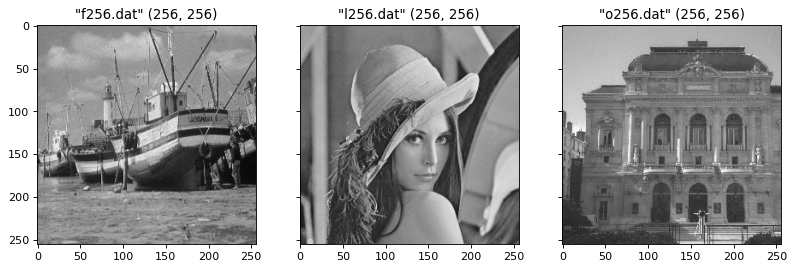

In [4]:
# Matrix dimensions
cols = 3
rows = 1

# Create figure with rows × cols subplots
fig, axs = plt.subplots(rows, cols, dpi=80, sharex=True, sharey=True)
fig.set_size_inches(4 * cols, 4.5 * rows)

# Iterate for all images
for idx, image_dict in enumerate(images):
    filename = image_dict['filename']
    image = image_dict['orig']

    # Set subplot title as '"filename" (rows, cols)' 
    axs[idx].set_title('"{}" {}'.format(
        filename + ext_inp,
        image.shape
    ))
    # Add subplot to figure plot buffer
    axs[idx].imshow(
        image,
        cmap='gray',
        vmin=0,
        vmax=255
    )

    # Save original image as .bmp file
    plt.imsave(
        path_out_orig + ext_out[1:] + '/' + filename + ext_out,
        image,
        cmap='gray',
        vmin=0,
        vmax=255
    )

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

# Display the figure
plt.show()

## Additive Noise Corruption

In [5]:
def add_noise(image, p: int, q: int):
    height, width = image.shape

    n_pixels = height * width
    n_p = (n_pixels * p) // 100
    pixels = set()
    for i in range(n_p):
        while True:
            curr = random.randint(0, n_pixels - 1)
            row = curr // width
            col = curr % width
            if (row, col) not in pixels:
                pixels.add((row, col))
                break

    noisy_image = np.zeros((height, width))

    def min(a, b):
        return a if a < b else b

    for i in range(height):
        for j in range(width):
            noisy_image[i][j] = image[i][j]

    for row, col in pixels:
        noisy_image[row][col] = min(
            255,
            int(noisy_image[row][col]) + int(image[row][col] * (random.randint(0, q) / 100))
        )
            
    noisy_image = noisy_image.astype('uint8')

    return noisy_image

## Image Difference

In [6]:
def difference_image(image_a, image_b):
    height, width = image_a.shape
    img = abs(image_a - image_b)
    for i in range(height):
        for j in range(width):
            img[i][j] = 0 if img[i][j] < 0 else img[i][j]
    return img

## Image Filtering

In [7]:
def mean(elems):
    sum = 0
    for i in elems:
        sum += i
    return sum // len(elems)

In [8]:
def filter_img(image, operation, w_size):
    height, width = image.shape
    img = np.zeros(image.shape)

    def get_pixel(i, j):
        return image[i][j] if (i >= 0 and j >=0) and (i < height and j < width) else 0 

    p_list = list(range(w_size))
    for i in range(w_size):
        p_list[i] -= w_size // 2

    for i in range(height):
        for j in range(width):
            elems = []
            for m in p_list:
                for n in p_list:
                    elems.append(get_pixel(i + m, j + n))
            img[i][j] = operation(elems)
    img.astype('uint8')

    return img

In [9]:
def save_dat(filename, data):
    np.savetxt(
        path_out_conv + ext_inp[1:] + '/' + filename + ext_inp,
        data,
        fmt=' %d',
        newline=' \n'
    )

def save_img(filename, image):
    plt.imsave(
        path_out_conv + ext_out[1:] + '/' + filename + ext_out,
        image,
        cmap='gray',
        vmin=0,
        vmax=255
    )

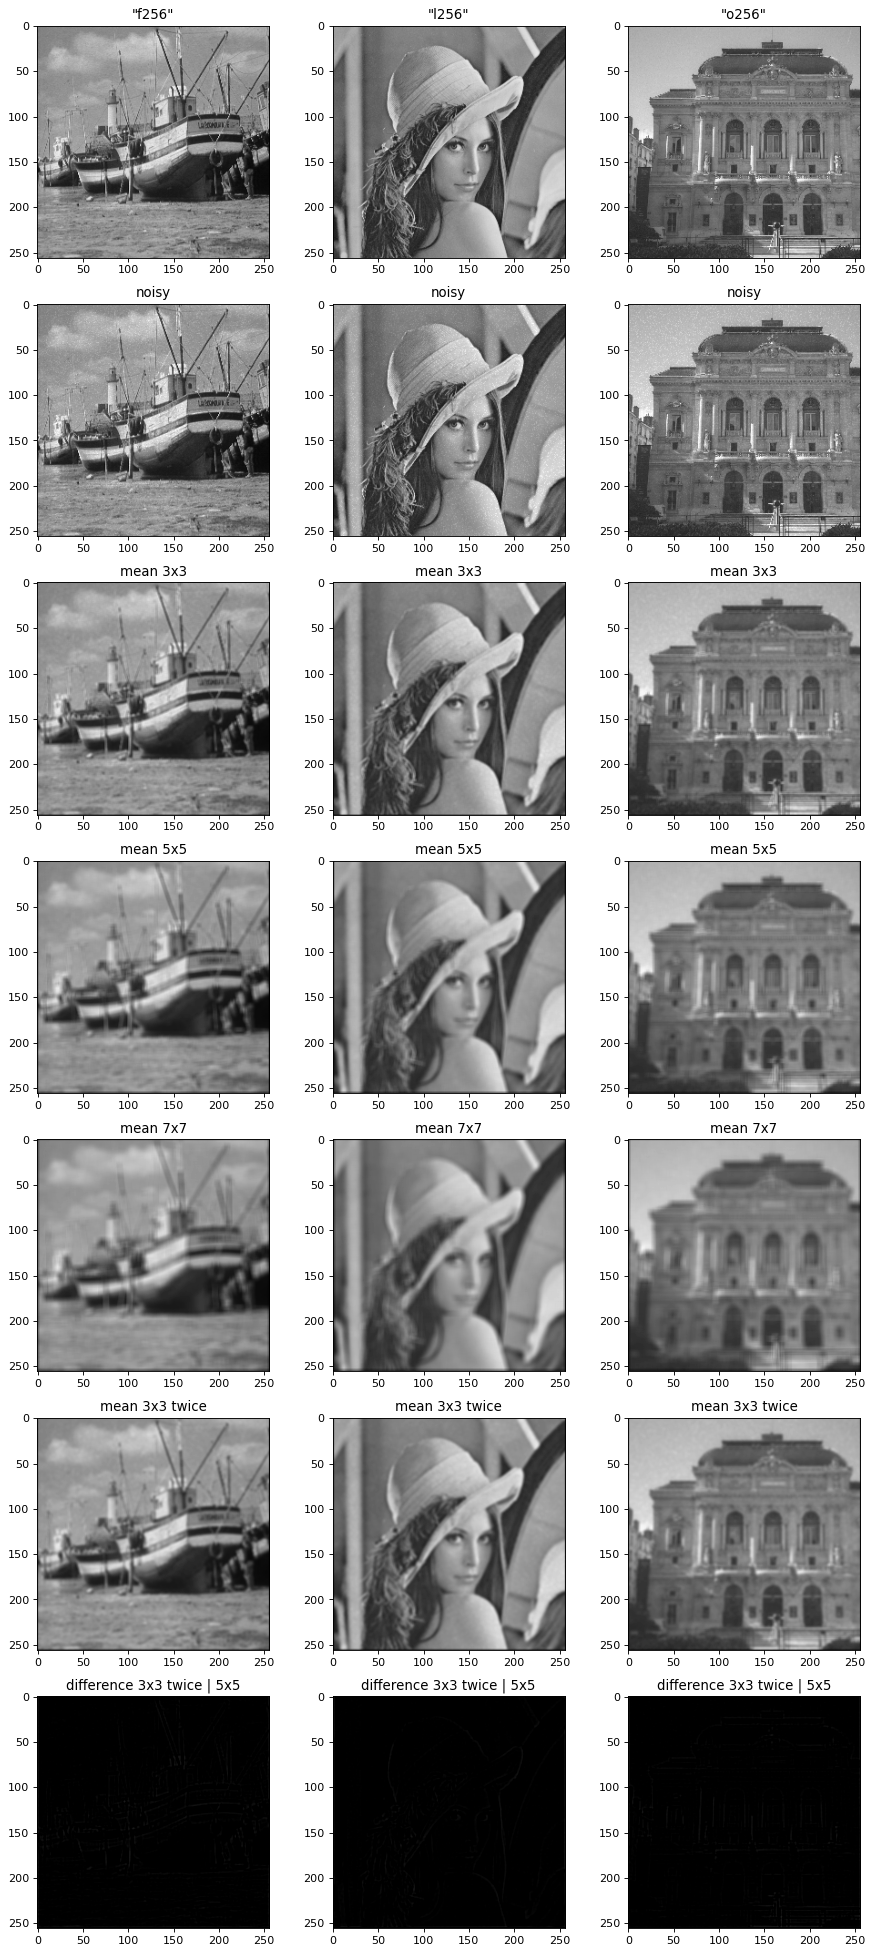

In [10]:
rows, cols = 7, len(images)

# Create figure with rows × cols subplots
fig, axs = plt.subplots(rows, cols, dpi=80)
fig.set_size_inches(4.5 * cols, 4.5 * rows)

# Iterate for all images
for idx, image_dict in enumerate(images):
    filename = image_dict['filename']

    orig = image_dict['orig']
    noisy = add_noise(orig, 25, 15)
        
    axs[0, idx].set_title(f'"{filename}"')
    axs[0, idx].imshow(orig, cmap='gray', vmin=0, vmax=255)
    
    axs[1, idx].set_title(f'noisy')
    axs[1, idx].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    save_dat(filename + f'_noisy', noisy)
    save_img(filename + f'_noisy', noisy)
    
    mean_3 = filter_img(noisy, mean, 3)
    axs[2, idx].set_title(f'mean 3x3')
    axs[2, idx].imshow(mean_3, cmap='gray', vmin=0, vmax=255)
    save_dat(filename + f'_mean_3', mean_3)
    save_img(filename + f'_mean_3', mean_3)
    
    mean_5 = filter_img(noisy, mean, 5)
    axs[3, idx].set_title(f'mean 5x5')
    axs[3, idx].imshow(mean_5, cmap='gray', vmin=0, vmax=255)
    save_dat(filename + f'_mean_5', mean_5)
    save_img(filename + f'_mean_5', mean_5)
    
    mean_7 = filter_img(noisy, mean, 7)
    axs[4, idx].set_title(f'mean 7x7')
    axs[4, idx].imshow(mean_7, cmap='gray', vmin=0, vmax=255)
    save_dat(filename + f'_mean_7', mean_7)
    save_img(filename + f'_mean_7', mean_7)

    mean_3_x2 = filter_img(filter_img(noisy, mean, 3), mean, 3)
    axs[5, idx].set_title(f'mean 3x3 twice')
    axs[5, idx].imshow(mean_3_x2, cmap='gray', vmin=0, vmax=255)
    save_dat(filename + f'_mean_3_x2', mean_3_x2)
    save_img(filename + f'_mean_3_x2', mean_3_x2)

    diff = mean_3_x2 - mean_5
    axs[6, idx].set_title(f'difference 3x3 twice | 5x5')
    axs[6, idx].imshow(diff, cmap='gray', vmin=0, vmax=255)
    save_dat(filename + f'_diff_5__3_x2', diff)
    save_img(filename + f'_diff_5__3_x2', diff)

# Save and display the figure
plt.savefig('mean_filter.jpg')
plt.show()

## Resource

**GitHub repository: ** [`Image Processing and Pattern Recognition`](https://github.com/meganindya/btech-assignments/tree/main/image-processing-pattern-recognition) - [`Anindya Kundu (meganindya)`](https://github.com/meganindya)